In [1]:
library(xts)
library(TTR)
library(stringr)
library(ggplot2)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



In [2]:
#Set Johns Hopkins github data urls
COVIDRecovered <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
COVIDDeaths <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
COVIDConfirmed <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
COVIDUSConfirmed <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
COVIDUSDeaths <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"

#Import raw data into data tables
Confirmed <- read.csv(url(COVIDConfirmed),check.names=FALSE)
Deaths <- read.csv(url(COVIDDeaths),check.names=FALSE)
Recovered <- read.csv(url(COVIDRecovered),check.names=FALSE)
USConfirmed <- read.csv(url(COVIDUSConfirmed),check.names=FALSE)
USDeaths <- read.csv(url(COVIDUSDeaths),check.names=FALSE)

#Read US metro areas and aggregate counties
CBSA <- read.csv("CBSA_2020.csv")

CBSA$FIPS <- as.numeric(paste0(str_pad(CBSA$FIPS.State.Code,2,pad="0"),
                               str_pad(CBSA$FIPS.County.Code, 3, pad = "0")))

CBSAConf.df <- aggregate(. ~ CBSA.Title, merge(CBSA,USConfirmed), sum, na.rm=TRUE)[,-c(2:18)]
CBSADeath.df <- aggregate(. ~ CBSA.Title, merge(CBSA,USDeaths), sum, na.rm=TRUE)[,-c(2:19)]

colnames(Confirmed)[2] <- c("Country")
colnames(Deaths)[2] <- c("Country")
Confirmed <- aggregate(. ~ Country, Confirmed[-c(1,3,4)], sum, na.rm=TRUE)
Deaths <- aggregate(. ~ Country, Deaths[-c(1,3,4)], sum, na.rm=TRUE)
Confirmed$Country <- as.character(Confirmed$Country)
Deaths$Country <- as.character(Deaths$Country)

In [3]:
countries.selected <- read.csv("countries.selected.csv",as.is = c(TRUE, FALSE))

In [4]:
countries.selected

X,Country,Population2018
17,Belgium,11427054
35,Chile,18729160
36,China (People's Republic of),1392730000
67,Greece,10732882
77,India,1352617328
81,Ireland,4867316
82,Israel,8882800
155,Spain,46797754
169,Turkey,82319724
170,United States,326687501


In [5]:
Confirmed[Confirmed$Country == "US",]$Country <- c("United States")
Confirmed[Confirmed$Country == "China",]$Country <- c("China (People's Republic of)")
Confirmed[Confirmed$Country == "Korea, South",]$Country <- c("Korea")
Confirmed[Confirmed$Country == "Czechia",]$Country <- c("Czech Republic")
Deaths[Deaths$Country == "US",]$Country <- c("United States")
Deaths[Deaths$Country == "China",]$Country <- c("China (People's Republic of)")
Deaths[Deaths$Country == "Korea, South",]$Country <- c("Korea")
Deaths[Deaths$Country == "Czechia",]$Country <- c("Czech Republic")

In [6]:
case.out <- Confirmed[Confirmed$Country %in% countries.selected$Country,]
death.out <- Deaths[Deaths$Country %in% countries.selected$Country,]
case.out.pop <- merge(case.out, countries.selected[,c("Country","Population2018")], by = "Country")
death.out.pop <- merge(death.out, countries.selected[,c("Country","Population2018")], by = "Country")

In [7]:
txfunc <- function(a,d=TRUE,per=7) {
    rownames(a) <- a[,1]
    a <- a[,-1]
    for (i in 1:(ncol(a)-1)) {
        a[,i] <- (a[,i]/a$Population2018)*100000
    }
    x <- t(a[,-1])
    xdf <- as.data.frame(x[-1,])
    xdf <- xdf[-nrow(xdf),]
    xdf$Date <- as.Date(rownames(xdf), format = "%m/%e/%y")
    xdf <- xdf[,c(ncol(xdf),1:(ncol(xdf)-1))]
    xdf[,-1] <- lapply(xdf[,-1], function(x) {as.numeric(as.character(x))})
    xdf.xts <- xts(xdf[,-1], order.by=xdf[,1])
    xdf.xts.diff <- diff(xdf.xts)
    xdf.xts.diff <- xdf.xts.diff[!is.na(index(xdf.xts.diff))]
    xdf.xts.diff.sma <- as.xts(do.call(cbind,(lapply(xdf.xts.diff, SMA, per))))
    names(xdf.xts.diff.sma) <- names(xdf.xts.diff)
    if (d == TRUE) {return(xdf.xts.diff.sma[-c(1:per),])}
    if (d == FALSE) {return(xdf.xts)}
}

In [8]:
case.out.pop.diff <- txfunc(case.out.pop)
death.out.pop.diff <- txfunc(death.out.pop)
write.csv(as.data.frame(case.out.pop.diff), "casediff.csv")
write.csv(as.data.frame(death.out.pop.diff), "deathdiff.csv")

In [9]:
case.out.pop.cum <- txfunc(case.out.pop,d=FALSE)

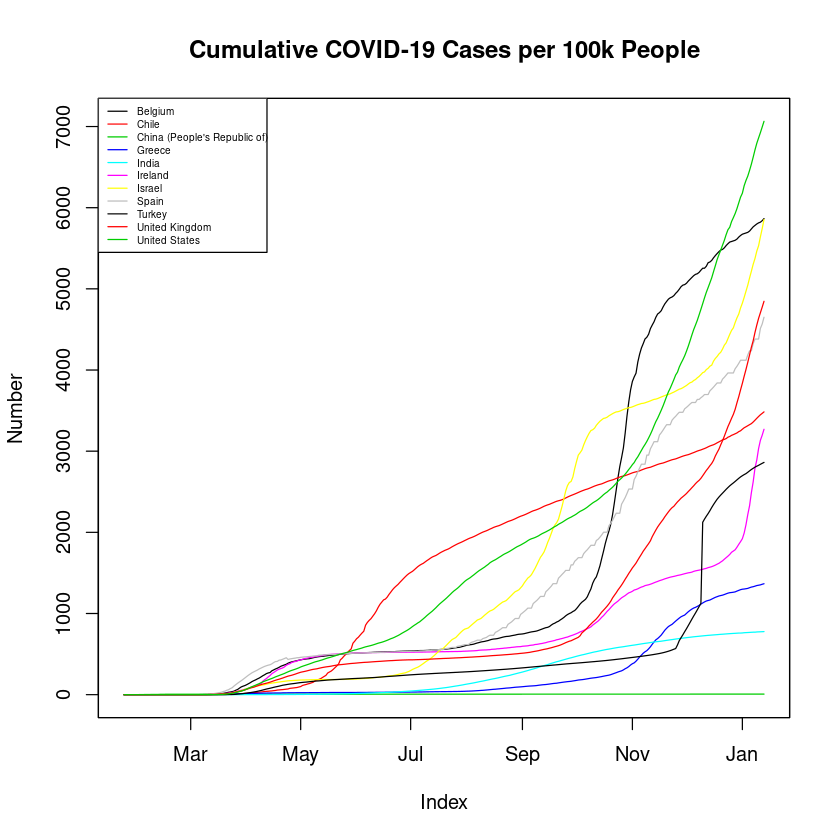

In [10]:


par(mfrow=c(1, 1))
plot.zoo(case.out.pop.cum, plot.type="single",col = c(1:length(colnames(case.out.pop.cum))),ylab = "Number",
         main = "Cumulative COVID-19 Cases per 100k People")
legend("topleft", legend = colnames(case.out.pop.cum), lty = c(1, 1), cex=0.5,
       col = c(1:length(colnames(case.out.pop.cum))))

In [ ]:
#FOR FULL SET WITH DEMO DATA

In [44]:
COVIDDEMO <- read.csv("COVID_Totals_Demo.csv",as.is = c(TRUE, FALSE))
COVIDDEMO$Country <- as.character(COVIDDEMO$Country)
COVIDDEMO[COVIDDEMO$Country == "US",]$Country <- c("United States")
COVIDDEMO[COVIDDEMO$Country == "China",]$Country <- c("China (People's Republic of)")
COVIDDEMO[COVIDDEMO$Country == "Korea, South",]$Country <- c("Korea")
COVIDDEMO[COVIDDEMO$Country == "Czechia",]$Country <- c("Czech Republic")
COVIDDEMO <- na.omit(COVIDDEMO)

In [45]:
Confirmed.pop <- merge(Confirmed, COVIDDEMO[,c("Country","Population2018")], by = "Country")
Deaths.pop <- merge(Deaths, COVIDDEMO[,c("Country","Population2018")], by = "Country")

In [46]:
case.tot.pop.diff <- txfunc(Confirmed.pop)
death.tot.pop.diff <- txfunc(Deaths.pop)

In [47]:
write.csv(as.data.frame(case.tot.pop.diff), "casediffall.csv")
write.csv(as.data.frame(death.tot.pop.diff), "deathdiffall.csv")